$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$
### ITCS6155

# Machine Learning Methodology
### Performance Measurement, Overfitting, Regularization, and Cross-Validation 

In machine learning, *what is a good measure to assess the quality of a machine learning model?* Let us step back from what we have learned in class about ML techniques and think about this. 
In previous lectures, we have discussed various measures such a root mean square error (RMSE), mean square error (MSE), mean absolute error (MAE) for regression problems, and accuracy, confusion matrix, precision/recall, F1-score, receiver operating characteristic (ROC) curve, and others for classification. 

Are these measures good enough to say a specific model is better than the other? 

Let us take a look at following codes examples.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy as copy

In [3]:
x = np.arange(3)
t = copy(x)

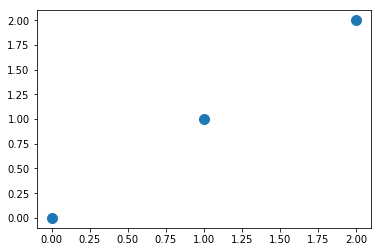

In [4]:
def plot_data():
    plt.plot(x, t, "o", markersize=10)
    
plot_data()

I know that it is silly to apply a linear regression on this obvious model, but let us try. :) 

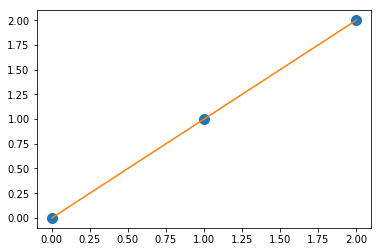

In [67]:
## Least Square solution
# TODO: Fill your codes here to fit and plot as my output
N = x.shape[0]
X1 = np.hstack((np.ones((N, 1)), x.reshape((x.shape[0], -1))))
w_ = np.linalg.inv(X1.T @ X1) @ X1.T @ t 
y = X1 @ w_
plot_data()
plt.plot(y)

Can we try a nonlinear model on this data? Why not? 
We can make a nonlinear model by simply adding higher degree terms such square, cubic, quartic, and so on. 

$$ f(\xv; \wv) = w_0 + w_1 \xv + w_2 \xv^2 + w_3 \xv^3 + \cdots $$

Let us make the polynomial regression model and fit to the data above with lease squares.

In [106]:
# Polinomial regression
def poly_regress(x, d=3, t=None, **params):
    bnorm = params.pop('normalize', False)
    
    X_poly = []
    # append polynomial terms
    for i in range(d+1):
        X_poly.append(x**i)
#     print(X_poly)
    X_poly = np.vstack(X_poly).T
#     print(X_poly)
    w=np.zeros(X_poly.shape[0])
    # normalize 
    if bnorm:
        mu, sd = np.mean(X_poly[:, 1:, None], axis=0), np.std(X_poly[:, 1:, None], axis=0)
        X_poly[:, 1:] = (X_poly[:, 1:] - mu.flat) / sd.flat
        
    # least sqaures
    if t is not None:
        # TODO: add least square solution here
#         print("here")
#         w2 = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ t
#         print(w2)
#         w1 = np.linalg.solve(X_poly.T @ X_poly, X_poly.T @ t)
#         print(w1)
        w = np.linalg.lstsq(X_poly.T @ X_poly, X_poly.T @ t)[0]
#         print(w)
        if bnorm:
            return X_poly, mu, sd, w
        return X_poly, w
    
    if bnorm:
        print("here")
        return X_poly, mu, sd
    return X_poly

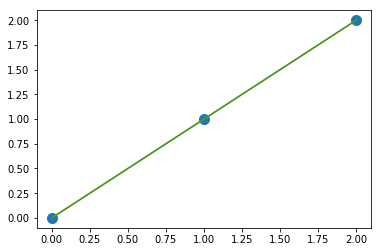

In [107]:
# print(x)
Xp, wp = poly_regress(x, 3, t)
yp = Xp @ wp

plot_data()
plt.plot(x, y)
plt.plot(x, yp)

Hmm... They both look good on this. Then, what is the difference? Let us take a look at how they change if I add the test data. If I compare the MSE, they are equivalent. Try to expand the data for test and see how different they are. 

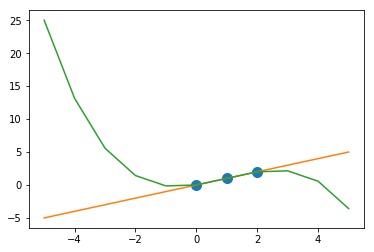

In [108]:
xtest = np.arange(11)-5
# print(xtest)
Xptest = poly_regress(xtest, 3)
# print(Xptest)
# print(wp)
yptest = Xptest @ wp
# print(yptest)

X1test = np.vstack((np.ones(len(xtest)), xtest)).T
ytest = X1test @ w

plot_data()
plt.plot(xtest, ytest)
plt.plot(xtest, yptest)


Now, what is your pick? Which model looks better? 

<br/><br/><br/><br/><br/><br/>

## Learning Curve

From the above example, we realized that the model evaluation we discussed so far is not enough. 

First, let us consider how well a learned model generalizes to new data with respect to the number of training samples. We assume that the test data are drawn from same distribution over example space as training data.  



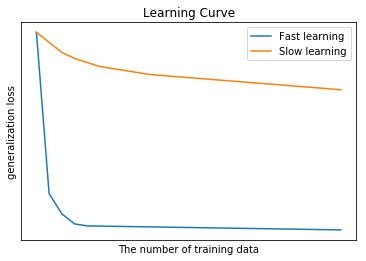

In this plot, we can compare the two learning algorithms and find which one generalizes better than the other. Also, during the training, we can access to the training error (or empirical loss). This may not look similar (mostly not) to the test error (generalization loss above). 

Let us take a look at the example in the textbook. 

In [109]:
import os
import pandas as pd
import sklearn

def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices], full_country_stats[["GDP per capita", 'Life satisfaction']]

In [110]:
!curl https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/lifesat/oecd_bli_2015.csv > oecd_bli_2015.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  395k    1  7434    0     0   7434      0  0:00:54 --:--:--  0:00:54 14868
100  395k  100  395k    0     0   395k      0  0:00:01  0:00:01 --:--:--  298k


In [111]:
!curl https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/lifesat/gdp_per_capita.csv > gdp_per_capita.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 36323  100 36323    0     0  36323      0  0:00:01 --:--:--  0:00:01  113k


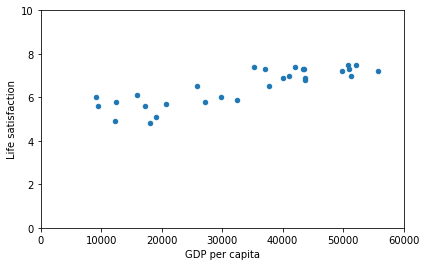

In [112]:
# Load the data
oecd_bli = pd.read_csv("oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")


# Prepare the data
country_stats, full_country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(6.5,4))
plt.axis([0, 60000, 0, 10])
plt.show()

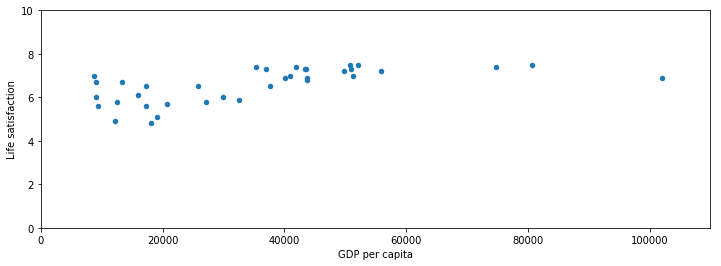

In [114]:
# Visualize the full data
# Visualize the data
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(12,4))
plt.axis([0, 110000, 0, 10])
plt.show()

In [115]:
# Data for training
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]

print(Xfull.shape, yfull.shape)

(36, 1) (36, 1)


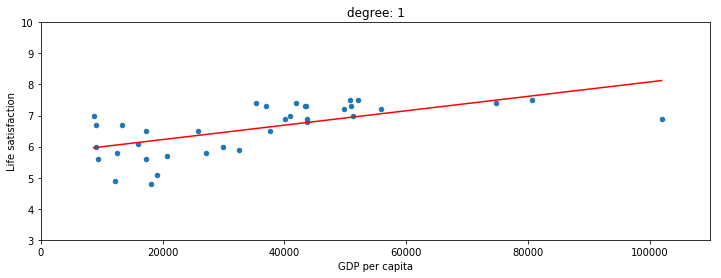

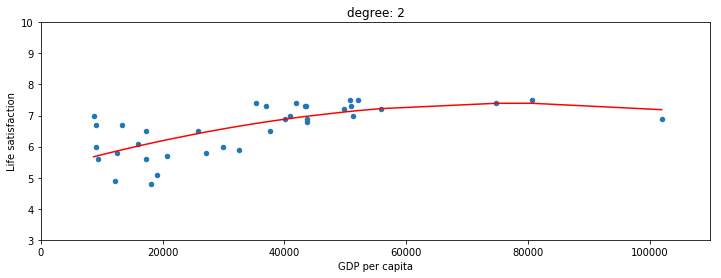

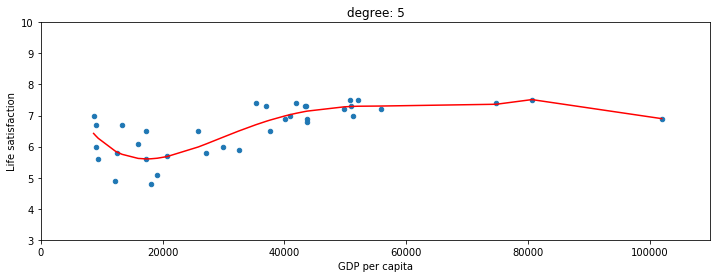

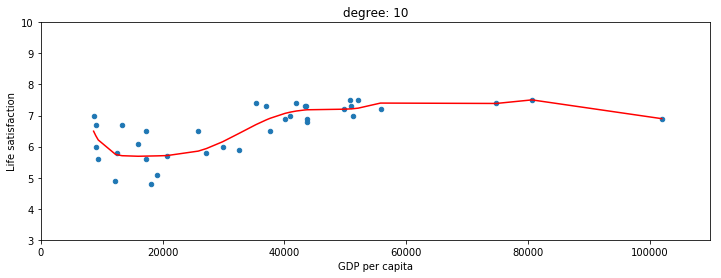

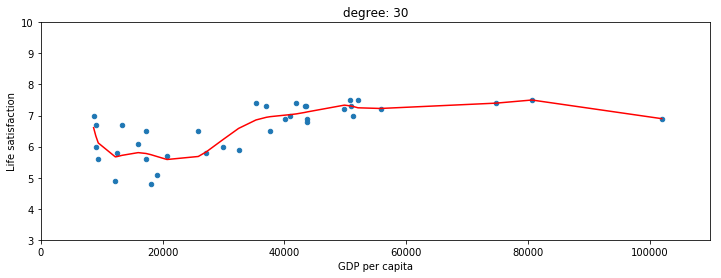

In [117]:
# polynomial model to this data

for deg in [1, 2, 5, 10, 30]:
    plt.figure();
    full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction',
                            figsize=(12,4));
    plt.axis([0, 110000, 3, 10]);
    Xp, mu, sd, wp = poly_regress(Xfull.flatten(), deg, yfull.flatten(), normalize=True)
    yp1 = Xp @ wp

    # plot curve 
    plt.plot(Xfull, yp1, 'r-', label=deg);
    plt.title("degree: {}".format(deg));



As the complexity of model grows, you may have small training errors. However, there is no guarantee that you have a good generalization (you may have very bad generalization error!). 
This is called **Overfitting** problem in machine learning. From training data, once you learned the hypothesis *h* (or machine learning model), you can have training error $E_{train}(h)$ and testing error $E_{test}(h)$. Let us say that there is another model $h^\prime$ for which

$$ E_{train}(h) < E_{train}(h^\prime) \wedge E_{test}(h) > E_{test}(h^\prime).$$

Then, we say the hypothesis $h$ is "overfitted." 

## Bias-Variance Tradeoff

Here the bias refers an error from erroneous assumptions and the variance means an error from sensitivity to small variation in the data. Thus, high bias can cause an underfitted model and high variance can cause an overfitted model. Finding the sweet spot that have good generalization is on our hand. 

In the same track of discussion, Scott summarizes the errors that we need to consider as follows: 

- high bias error: under-performing model that misses the important trends
- high variance error: excessively sensitive to small variations in the training data
- Irreducible error: genuine to the noise in the data. Need to clean up the data

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/bias-and-variance.jpg)
<center>From Understanding the Bias-Variance Tradeoff, by Scott Fortmann-Roe</center>

## Regularization

We reduce overfitting by addding a complexity penalty to the loss function. Here follows the loss function for the linear regression with $L2$-norm. 

$$
\begin{align*}
E(\wv) &= \sum_i^N ( y_i - t_i)^2 + \lambda \lVert \wv \rVert_2^2  \\
  \\
  &= \sum_i^N ( y_i - t_i)^2 + \lambda \sum_k^D w_k^2 \\
  \\
  &= (\Xm \wv - T)^\top (\Xm \wv - T)  + \lambda \wv^\top \wv \\
  \\
  &= \wv^\top \Xm^\top \Xm \wv - 2 \Tm^\top \Xm \wv + \Tm^\top \Tm  + \lambda \wv^\top \wv 
\end{align*}
$$

Repeating the derivation as in linear regression, 

$$
\begin{align*}
\frac{\partial E(\wv)}{\partial \wv} &= \frac{\partial (\Xm \wv - \Tm)^\top (\Xm \wv - \Tm)}{\partial \wv} + \frac{\partial \lambda \wv^\top \wv}{\partial \wv} \\
        \\
        &= 2 \Xm^\top \Xm \wv - 2 \Xm^\top \Tm + 2 \lambda \wv
\end{align*}
$$

Setting the last term zero, we reach the solution of *ridge regression*: 

$$
\begin{align*}
 2 \Xm^\top \Xm \wv - 2 \Xm^\top \Tm  + 2 \lambda \wv &= 0\\
\\
\big(\Xm^\top \Xm + \lambda \Im \big) \wv &= \Xm^\top \Tm\\
\\
\wv &= \big(\Xm^\top \Xm + \lambda \Im \big)^{-1} \Xm^\top \Tm.
\end{align*}
$$


## Cross-Validation

Now, let us select a model. Even with the regularization, we still need to pick $\lambda$. For polynomial regression, we need to find the degree parameter. When we are mix-using multiple algorithms, we still need to know which model to choose. 
Here, remembe that we want a model that have good generalization. The idea is preparing one dataset (a validation set) by pretending that we cannot see the labels. After choosing a model parameter (or a model) and train it with training dataset, we test it on the validation data. 
Comparing the validation error, we select the one that has the lowest validation error. Finally, we evaluate the model on testing data. 

Here follows the K-fold cross-validation that divides the data into K blocks for traing, validating and testing.

### K-fold CV Procedure


>  Choose K for K-fold cross validation.

>  Set nfold = 0. 

>  Initialize the lists *res* = [], *testErrs* = [].

>  Split data X and label T into K number of partitions.

>  For each TEST partition 

>>  For each validation partition among the rest partitions 

>>>  Choose the rest partitions into a training set.

>>>  For each set __P__ of parameters to test

>>>>   Using __P__, train the model 

>>>>   Use the trained model on the validation data

>>>>   Evaluate the validation result and store the restuls to *res*

>>  From the *res* result, pick the one with the best result.

>>  Retrain the model with the best parameter __p__ in __P__.

>>  Apply the model with the best parameter __p*__ to the test dataset. 

>>  Evaluate the result *err* and store the tuple (__p*__, *err*) to *testErrs*. 

>  Return *testErrs*. 


## Feature Selection

Another way to get a sparse (possibly good generalization) model is using small set of most relevant features. Weight analysis or some other tools can give us what is most relevant or irrelevant features w.r.t the training error. But it is still hard to tell the relevance to the generalization error. Thus,    problems in choosing a minimally relevant set of features is NP-hard even with perfect estimation of generalization error. With inaccurate estimation that we have, it is much hard to find them.  

Thus, we can simply use cross-validation to find features. 
We can greedily add (forward selection) or delete (backward selection) features that decrease cross-validation error most.  

# Practice

Now, try to write your own 5-fold cross validation code that follows the procedure above for ridge regression. Try 5 different $\lambda$ values, [0, 0.01, 0.1, 1, 10], for this.   

In [231]:
# TODO: try to implement your own K-fold CV.  
#      (This will be a part of next assignment (no solution will be provided.))
def CrossValidate(X, T, modelClass, alphas=None):
    K = 5 # num of partitions
    finalRecords = []
    XPart = np.array_split(X,K)
    TPart = np.array_split(T,K)
    bestAlpha = None
    
    for test in range(K): # for each fold
        records = []
        Xtest = XPart[test]
        Ttest = TPart[test]
        
        if alphas is None:
            bestModel = modelClass()
        else:
            for val in range(K): #test against remaining sections - determines best alpha
                if test == val:
                    continue

                Xval = XPart[val]
                Tval = TPart[val]

                Xtrain = np.concatenate([x for i,x in enumerate(XPart) if i!=val and i!=test])
                Ttrain = np.concatenate([x for i,x in enumerate(TPart) if i!=val and i!=test])

                for alpha in alphas:
                    model = modelClass(alpha)
                    model.train(Xtrain,Ttrain)
                    pred = model.use(Xval)

                    valErr = rmse(pred,Tval)
                    records.append((valErr,alpha))
                    
            records = np.array(records)
            bestAlpha = records[np.argmin(records[:,0])][1]
            bestModel = modelClass(bestAlpha)
        
        Xtrain = np.concatenate([x for i,x in enumerate(XPart) if i!=test])
        Ttrain = np.concatenate([x for i,x in enumerate(TPart) if i!=test])
        
        bestModel.train(Xtrain,Ttrain)
        finalPred = bestModel.use(Xtest)
        finalErr = rmse(finalPred, Ttest)
        finalRecords.append((finalErr,bestAlpha))
    
    return np.array(finalRecords)

def rmse(T, Y):
    return np.sqrt(np.sum((T-Y)**2))